In [57]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import skimage.restoration as res
from skimage.exposure import match_histograms
from skimage import exposure


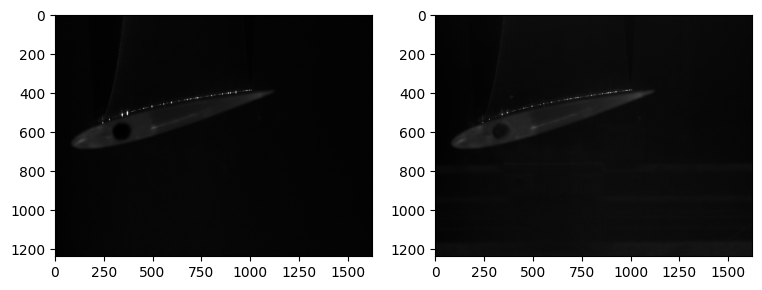

In [58]:
a = imread("../PIV_DATA/15deg/B00001.tif")
b = imread("../PIV_DATA/15deg/B00001.tif")

a = a[:a.shape[0]//2]
b = b[b.shape[0]//2+1:]

# a = res.denoise_tv_chambolle(a, weight=0.01, channel_axis=-1)
# b = res.denoise_tv_chambolle(b, weight=0.01, channel_axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
scale = 6e-6 * 81e3

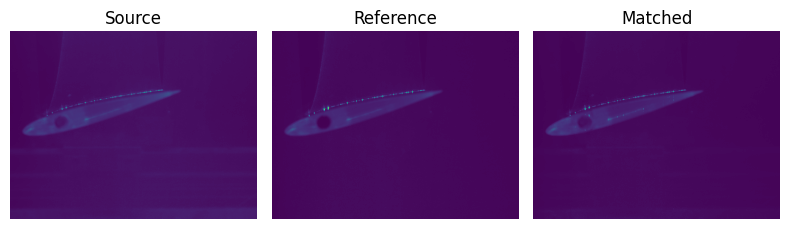

In [59]:
reference = a
image = b

matched = match_histograms(image, reference, channel_axis=-1)

fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True
)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()

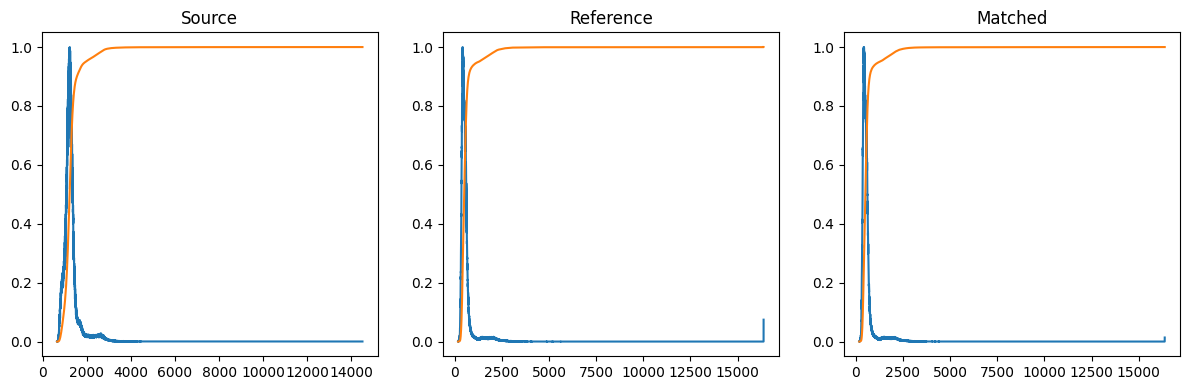

In [60]:


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))


for i, img in enumerate((image, reference, matched)):
    img_hist, bins = exposure.histogram(img)
    axes[i].plot(bins, img_hist / img_hist.max())
    img_cdf, bins = exposure.cumulative_distribution(img)
    axes[i].plot(bins, img_cdf)

axes[0].set_title('Source')
axes[1].set_title('Reference')
axes[2].set_title('Matched')

plt.tight_layout()
plt.show()

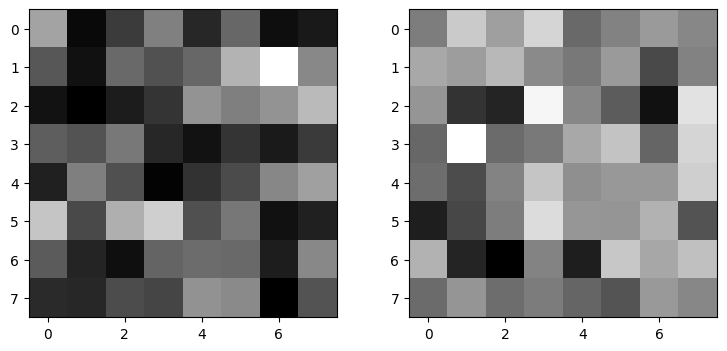

In [61]:
win_size = 16

a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)

Text(0.5, 1.0, 'Without shift')

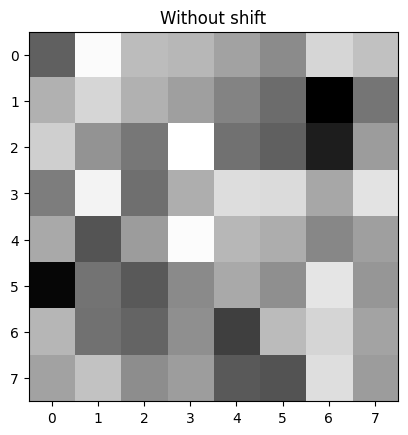

In [62]:
fig = plt.imshow(b_win - a_win, cmap=plt.cm.gray)
plt.title("Without shift")

Text(0.5, 1.0, 'Difference when A has been shifted by 1 pixel')

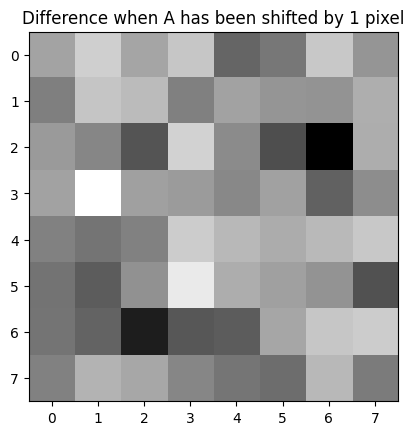

In [63]:
plt.imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
plt.title("Difference when A has been shifted by 1 pixel")

In [64]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) ** 2))
            if dist < best_dist:
                best_dist = dist
                best_shift = (y, x)
    return (best_dist, best_shift)

In [65]:
# let's test that it works by manually rolling (shifting circurlarly) the same
# image
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(0.0, (2, 0))

In [66]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
best_dist, best_shift = match_template(b_win, a_win)
print(f"{best_dist=}")
print(f"{best_shift=}")

best_dist=1320.0602258988035
best_shift=(1, 1)


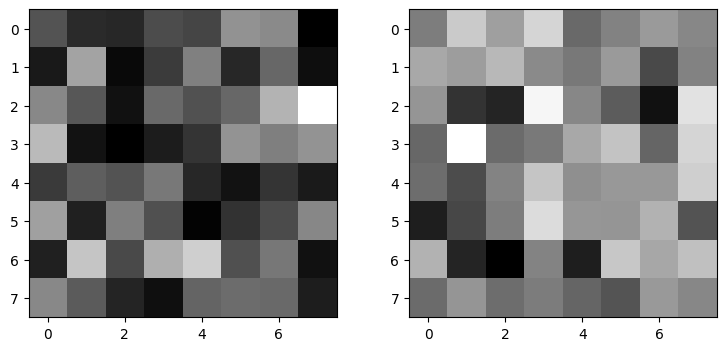

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(a_win, best_shift, axis=(0, 1)), cmap='gray')
axs[1].imshow(b_win, cmap='gray')
plt.show()

In [68]:
from scipy.signal import correlate

cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the correlation map: %d x %d" % cross_corr.shape)

Size of the correlation map: 15 x 15


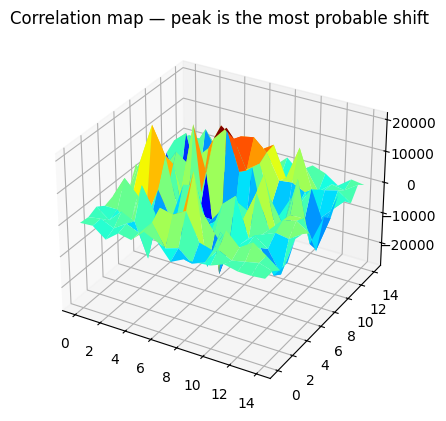

In [69]:
# let's see what the cross-correlation looks like
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))

ax.plot_surface(Y, X, cross_corr, cmap='jet', linewidth=0.2)  # type: ignore
plt.title("Correlation map — peak is the most probable shift")
plt.show()

y=6, x=2


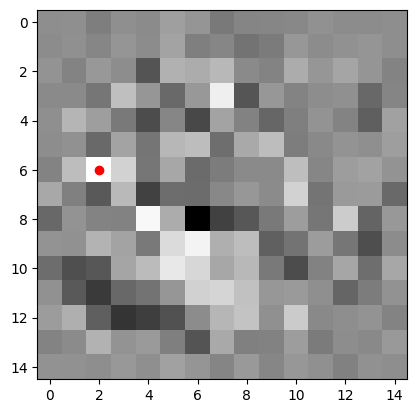

In [70]:
# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)

y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y=}, {x=}")

plt.plot(x, y, "ro")
plt.show()

In [71]:
dy, dx = y - 31, x - 31
print(f"{dy=}, {dx=}")

dy=-25, dx=-29


In [72]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            dys[iy, ix], dxs[iy, ix] = (
                np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                - np.array([win_size, win_size])
                + 1
            )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs/scale, dys / scale

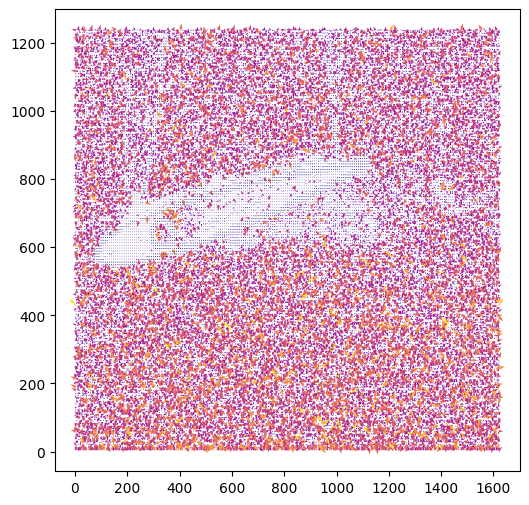

In [73]:
xs, ys, dxs, dys = vel_field(a, b, 8)
norm_drs = np.sqrt(dxs ** 2 + dys ** 2)

fig, ax = plt.subplots(figsize=(6, 6))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.6,
)
# ax.set_aspect("equal")
plt.show()

In [74]:
def vel_field_asymmetric_wins(
    curr_frame, next_frame, half_int_win_size, half_search_win_size
):
    ys = np.arange(half_int_win_size[0], curr_frame.shape[0], 2 * half_int_win_size[0])
    xs = np.arange(half_int_win_size[1], curr_frame.shape[1], 2 * half_int_win_size[1])
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[
                y - half_int_win_size[0] : y + half_int_win_size[0],
                x - half_int_win_size[1] : x + half_int_win_size[1],
            ]
            search_win_y_min = y - half_search_win_size[0]
            search_win_y_max = y + half_search_win_size[0]
            search_win_x_min = x - half_search_win_size[1]
            search_win_x_max = x + half_search_win_size[1]
            truncated_search_win = next_frame[
                max(0, search_win_y_min) : min(b.shape[0], search_win_y_max),
                max(0, search_win_x_min) : min(b.shape[1], search_win_x_max),
            ]
            cross_corr = correlate(
                truncated_search_win - np.mean(truncated_search_win),
                int_win - np.mean(int_win),
                mode="valid",
                method="fft",
            )
            dy, dx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
            # if the top of the search window got truncated, shift the origin
            # up to the top edge of the (non-truncated) search window
            if search_win_y_min < 0:
                dy += -search_win_y_min
            # if the left of the search window got truncated, shift the origin
            # over to the left edge of the (non-truncated) search window
            if search_win_x_min < 0:
                dx += -search_win_x_min
            # shift origin to the center of the search window
            
            dy -= (half_search_win_size[0] - half_int_win_size[0]) / scale
            dx -= (half_search_win_size[1] - half_int_win_size[1]) / scale
            dys[iy, ix] = dy
            dxs[iy, ix] = dx
    return xs, ys, dxs, dys

In [75]:
int_win_size = np.array([12, 14])
print(f"{int_win_size=}")
assert np.all(np.array(a.shape) % int_win_size == 0)
assert np.all(int_win_size % 2 == 0)
half_int_win_size = int_win_size // 2

search_win_size = int_win_size * 2
print(f"{search_win_size=}")
assert np.all(search_win_size % 2 == 0)
half_search_win_size = search_win_size // 2
assert np.all(search_win_size > int_win_size)
print(
    "max velocity that can be detected with these window sizes: "
    + f"{half_search_win_size - half_int_win_size}"
)

int_win_size=array([12, 14])
search_win_size=array([24, 28])
max velocity that can be detected with these window sizes: [6 7]


Text(0.5, 1.0, '12 x 14 int. win. + 24 x 24 unpadded search win.')

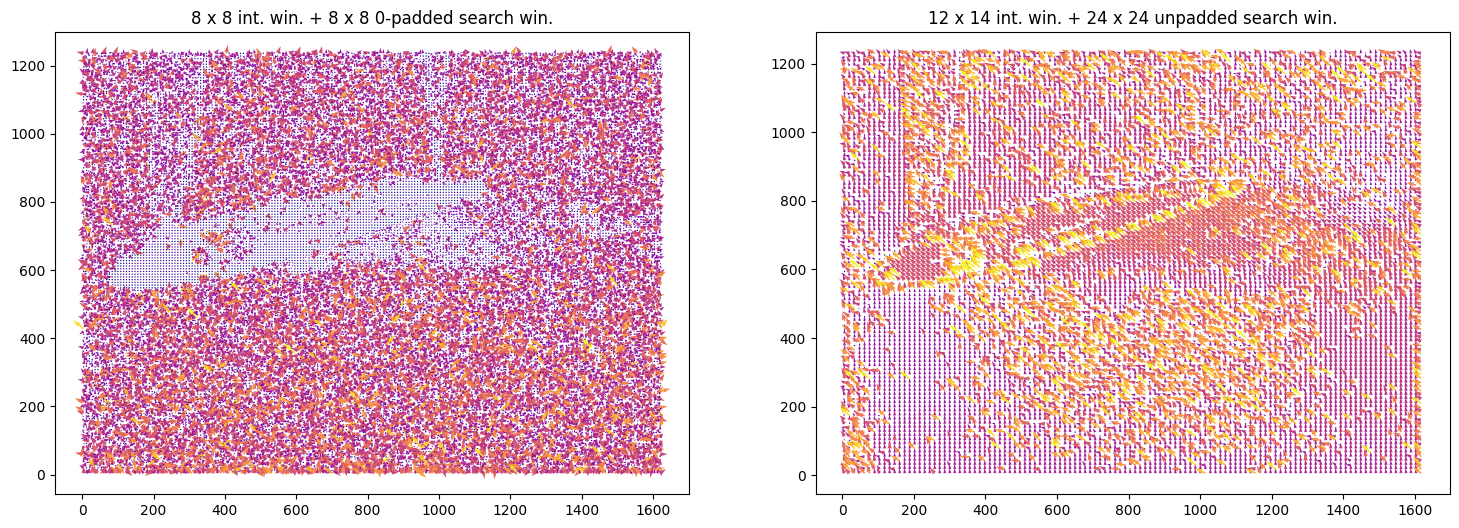

In [76]:
xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(
    a, b, half_int_win_size, half_search_win_size
)
norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.5,
)
axs[1].quiver(
    xs_asym,
    ys_asym[::-1],
    dxs_asym,
    -dys_asym,
    norm_drs_asym,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=0.5,
)
axs[0].set_title(
    f"{win_size} x {win_size} int. win. + "
    f"{win_size} x {win_size} 0-padded search win."
)
axs[1].set_title(
    f"{int_win_size[0]} x {int_win_size[1]} int. win. + "
    f"{search_win_size[0]} x {search_win_size[0]} unpadded search win."
)
# plt.colorbar()
# ax.set_aspect("equal")

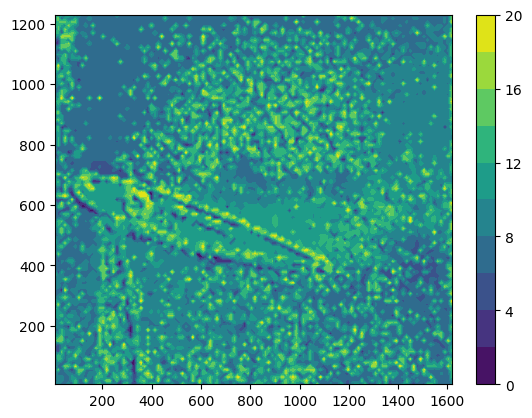

In [77]:
plt.contourf(xs_asym,ys_asym,norm_drs_asym,levels = 10,cmap = 'viridis')
plt.colorbar()